# Latency and Throughput per Packet

In this notebook, we take the schedules we generated and graph the latency of each packet v.s. number of mules and the throughput of each packet v.s. number of mules. We do this for both naive uploads and for batched uploads to see the effect that batching has on latency and throughput. Since batching delays uploads and limits the amount of data per upload, we expect latency to increase and throughput to decrease when we introduce batching.

## Latency

We start by calculating latency for each packet delivered. Note that this does not include packets that are not delivered. Wild.

Latency is the time between data generation and packet upload time.

In [1]:
# Import libraries.
import csv
import math
import numpy as np
import pandas as pd
from matplotlib import cm as cm
from matplotlib import pyplot as plt

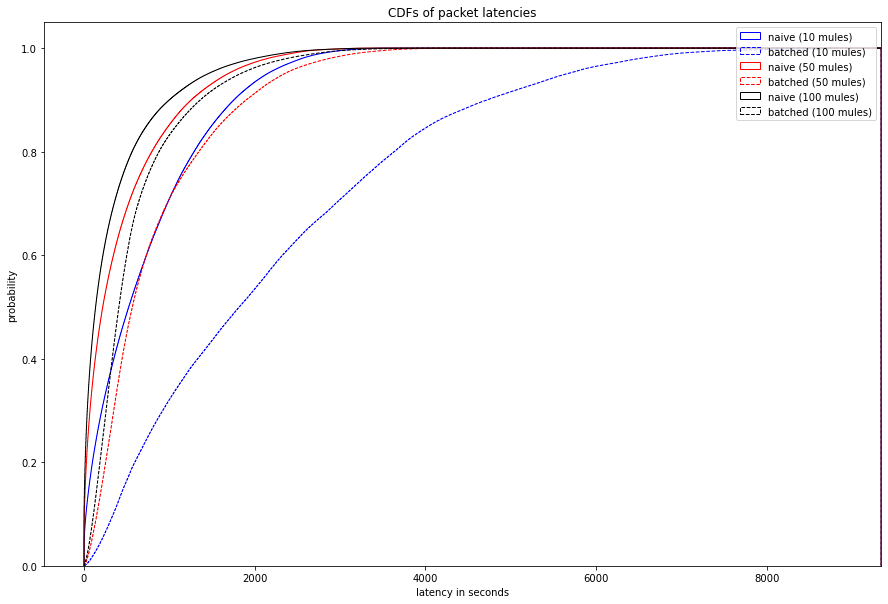

In [18]:
# generate latency cdfs for various numbers of mules
num_mules_list = [10, 50, 100] # integer <= 100
naive_latency_list = []
batch_latency_list = []
schedule_file = 'prob_data/random_uploads/vary_mules/{}_mule_schedule.csv'
colors = ['b','r','k'] #cm.brg(np.linspace(1, 0, len(num_mules_list)))
t_grain = 2
longest_latency = 0.0

plt.figure(figsize=(15,10))

for index, num_mules in enumerate(num_mules_list):
    schedule_df = pd.read_csv(schedule_file.format(num_mules), skiprows=3)
    schedule_df['naive_latency'] = schedule_df['pickup_time'] - schedule_df['sample_time']
    schedule_df['batch_latency'] = schedule_df['batch_time'] - schedule_df['sample_time']
    
    longest_latency = max(longest_latency, schedule_df['batch_latency'].max())

    naive_latency_list.append(schedule_df['naive_latency'].to_numpy())
    batch_latency_list.append(schedule_df['batch_latency'].to_numpy())

num_bins = math.ceil(longest_latency / t_grain)
t_edges = [t * t_grain for t in range(num_bins+1)]

for index, num_mules in enumerate(num_mules_list):
    plt.hist(naive_latency_list[index], bins=t_edges, density=True, cumulative=True, histtype='step', color=colors[index], linestyle='-', label='naive ({} mules)'.format(num_mules))
    plt.hist(batch_latency_list[index], bins=t_edges, density=True, cumulative=True, histtype='step', color=colors[index], linestyle='--', label='batched ({} mules)'.format(num_mules))

plt.legend()
plt.title('CDFs of packet latencies')
plt.xlabel('latency in seconds')
plt.ylabel('probability')
plt.xlim(right=longest_latency)
plt.show()


In the case of 100 mules, the sensors offload their data relatively frequently, so there's never a large backlog of data that needs to be uploaded, so the difference in latency between naive uploads and batched uploads is only a couple batch periods. However, as the number of mules decrease, sensors accumulate more data before seeing each subsequent mule, so each mule receives a large backlog of data each time they enter the range of a new sensor, resulting in more data than can be packed into the next batch, so latency increases substantially from naive uploads to batched uploads.

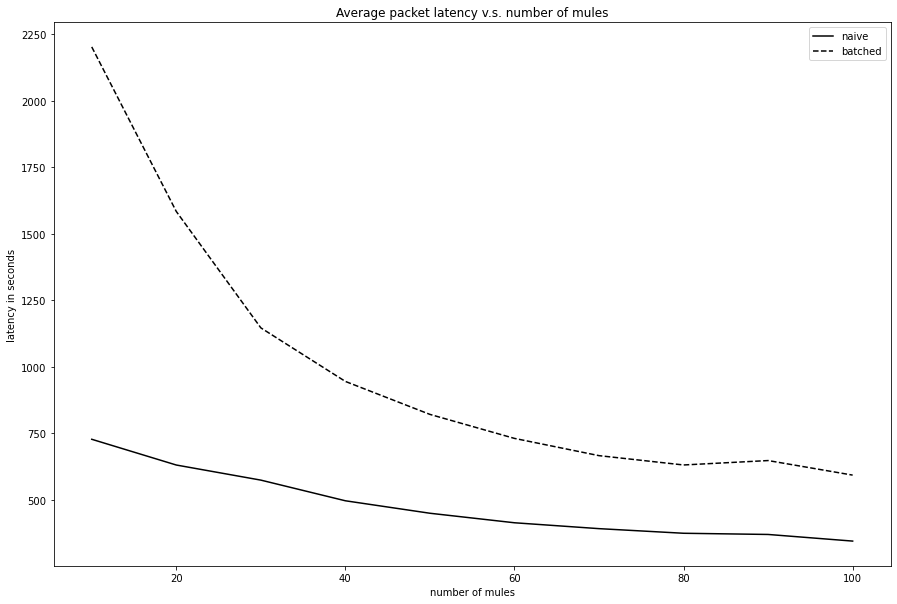

In [23]:
# generate a plot for how average latency changes over number of mules
num_mules_list = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100] # integer <= 100
naive_latencies = []
batch_latencies = []
schedule_file = 'prob_data/random_uploads/vary_mules/{}_mule_schedule.csv'

for index, num_mules in enumerate(num_mules_list):
    schedule_df = pd.read_csv(schedule_file.format(num_mules), skiprows=3)
    schedule_df['naive_latency'] = schedule_df['pickup_time'] - schedule_df['sample_time']
    schedule_df['batch_latency'] = schedule_df['batch_time'] - schedule_df['sample_time']

    naive_latencies.append(schedule_df['naive_latency'].mean())
    batch_latencies.append(schedule_df['batch_latency'].mean())

plt.figure(figsize=(15,10))
plt.plot(num_mules_list, naive_latencies, 'k-', label='naive')
plt.plot(num_mules_list, batch_latencies, 'k--', label='batched')
plt.legend()
plt.title('Average packet latency v.s. number of mules')
plt.ylabel('latency in seconds')
plt.xlabel('number of mules')
plt.show()


We see that average latency decreases as the number of mules increases, which makes sense. We see that this effect is partially due to sensors seeing mules more often (demonstrated with the decreasing `naive` line) and due to less data fitting in less batches (with the more steeply decreasing `batched` line).

## Throughput

Now we plot out throughput over number of mules, where throughput is average number of packets uploaded within the hour?

In [15]:
schedule_df = pd.read_csv('prob_data/random_uploads/schedule.csv', skiprows=3)
schedule_df.head()

,sensor_id,mule_id,sample_time,pickup_time,batch_time,data_length
0,697,0,0.0,1.501024,122,128
1,977,0,0.0,1.501024,122,128
2,624,0,0.0,3.501024,122,128
3,638,0,0.0,7.501024,122,128
4,17,0,20.0,20.001024,122,128


In [18]:
sum(schedule_df['pickup_time'] < 3600)


267467

In [19]:
sum(schedule_df['batch_time'] < 3600)


256854

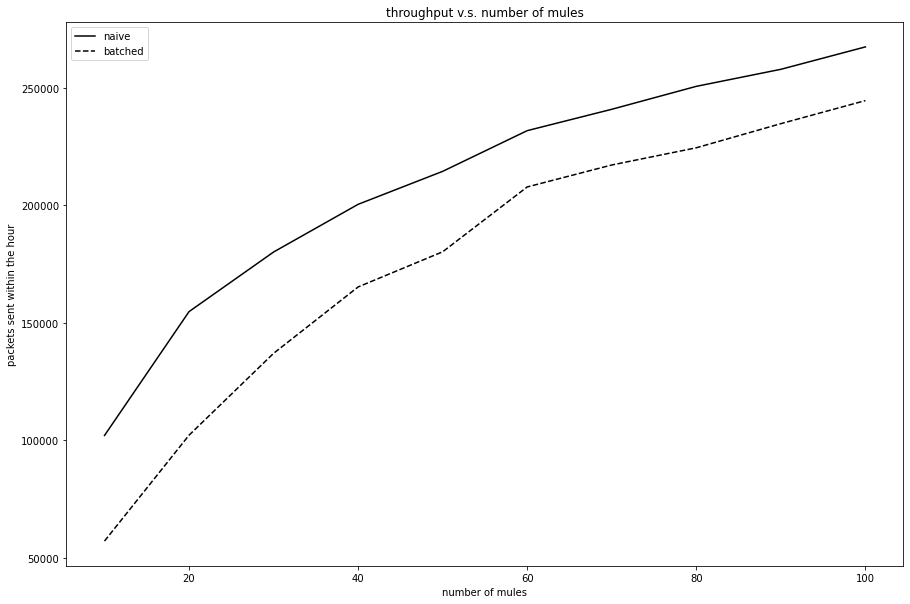

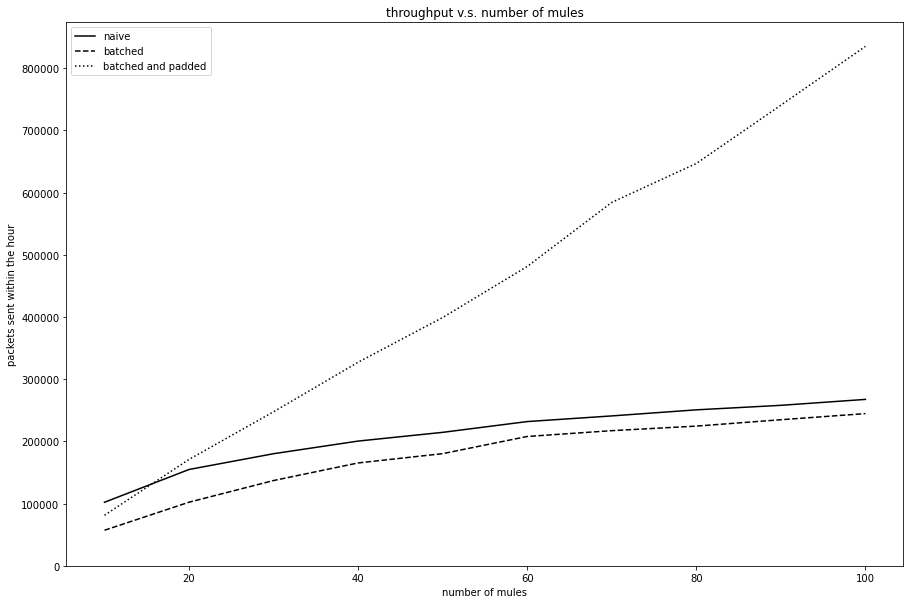

In [31]:
# do the same thing with multiple number of mules
num_mules_list = [10, 20, 30, 40, 50, 60, 70 ,80, 90, 100] # integer <= 100
schedule_file = 'prob_data/random_uploads/vary_mules/{}_mule_schedule.csv'
dummy_file = 'prob_data/random_uploads/vary_mules/{}_mule_dummy.csv'

naive_throughput = []
batch_throughput = []
padded_throughput = []

for num_mules in num_mules_list:
    schedule_df = pd.read_csv(schedule_file.format(num_mules), skiprows=3)
    naive_throughput.append(sum(schedule_df['pickup_time'] < 3600))
    batch_throughput.append(sum(schedule_df['batch_time'] < 3600))
    
    with open(dummy_file.format(num_mules), 'r') as f:
        reader = csv.DictReader(f)
        for row in reader:
            samples_per_batch = int(row['samples_per_batch'])
            break
    dummy_df = pd.read_csv(dummy_file.format(num_mules), skiprows=2)
    padded_throughput.append(sum(dummy_df['batch_time'] < 3600) * samples_per_batch)

plt.figure(figsize=(15,10))
plt.plot(num_mules_list, naive_throughput, 'k-', label='naive')
plt.plot(num_mules_list, batch_throughput, 'k--', label='batched')
plt.legend()
plt.title('throughput v.s. number of mules')
plt.xlabel('number of mules')
plt.ylabel('packets sent within the hour')
plt.show()

plt.figure(figsize=(15,10))
plt.plot(num_mules_list, naive_throughput, 'k-', label='naive')
plt.plot(num_mules_list, batch_throughput, 'k--', label='batched')
plt.plot(num_mules_list, padded_throughput, 'k:', label='batched and padded')
plt.legend()
plt.title('throughput v.s. number of mules')
plt.xlabel('number of mules')
plt.ylabel('packets sent within the hour')
plt.ylim(bottom=0)
plt.show()


We see that since packets are delayed through batching, we end up sending less packets within the hour when we batch v.s. just naive uploads, so we see the `naive` line above the `batch` line. The second figure has the same lines as the first figure, but also adds a `batched and padded` line that shows the total amount of upload traffic increases linearly as the number of mules increases, which makes sense as mules regularly send padded and dummy packets on a randomized upload schedule.

As the number of mules increases, the amount of sensor data held by any one sensor decreases, so the proportion of padding-to-data increases. We can see this more clearly in the plot of goodput below.

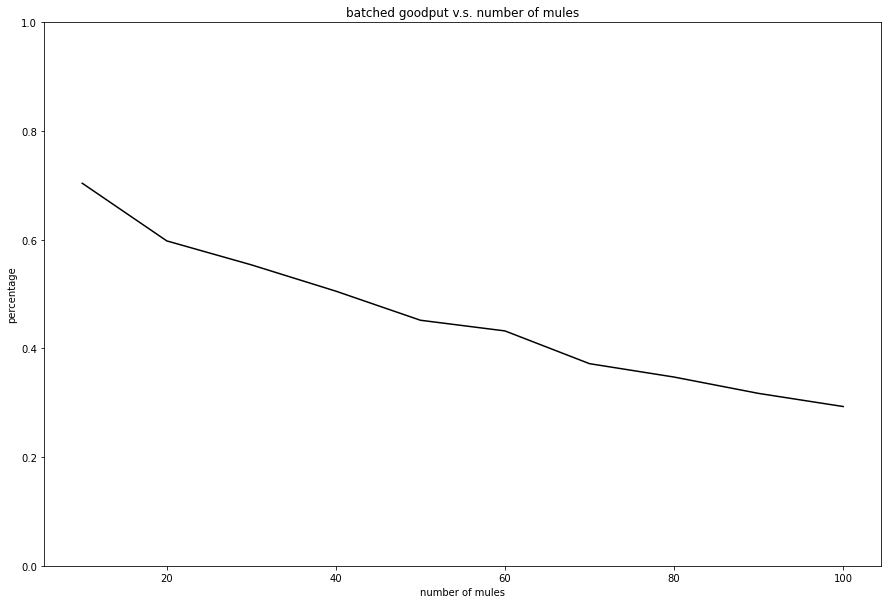

In [27]:
goodput = [batch/pad for batch, pad in zip(batch_throughput, padded_throughput)]
plt.figure(figsize=(15,10))
plt.plot(num_mules_list, goodput, 'k')
plt.title('batched goodput v.s. number of mules')
plt.xlabel('number of mules')
plt.ylabel('percentage')
plt.ylim(0, 1)
plt.show()

In the figure above, we see that as the number of mules increases, each batch that any mule sends contains less sensor data (since the sensors' data is distributed across the mules) so the ratio of `sensor data / total sent data` decreases as the amount of padding increases.

It would also be interesting to see the long tail of packets sent after the hour ends due to backlog and batching.

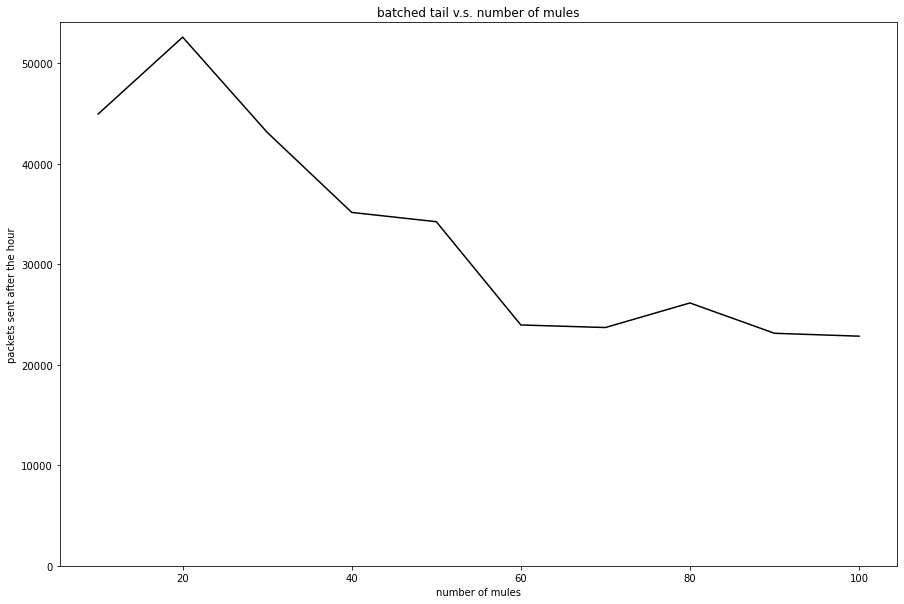

In [30]:
# See the 'tail' from batching
num_mules_list = [10, 20, 30, 40, 50, 60, 70 ,80, 90, 100] # integer <= 100
schedule_file = 'prob_data/random_uploads/vary_mules/{}_mule_schedule.csv'
batched_tail = []

for num_mules in num_mules_list:
    schedule_df = pd.read_csv(schedule_file.format(num_mules), skiprows=3)
    batched_tail.append(sum(schedule_df['batch_time'] >= 3600))

plt.figure(figsize=(15,10))
plt.plot(num_mules_list, batched_tail, 'k-')
plt.title('batched tail v.s. number of mules')
plt.xlabel('number of mules')
plt.ylabel('packets sent after the hour')
plt.ylim(bottom=0)
plt.show()

The figure above shoes that a decent amount of sensor data is being sent after the simulation ends. Part of it is due to the delay from batching, which we see in the cases of around 60-100 mules. However, when we have less than 60 mules, we start seeing the backlog building up, resulting in more and more packets being sent after the hour, and subsequently a long tail of uploads.